#### Architecture - Semantic Search using Elastic Search


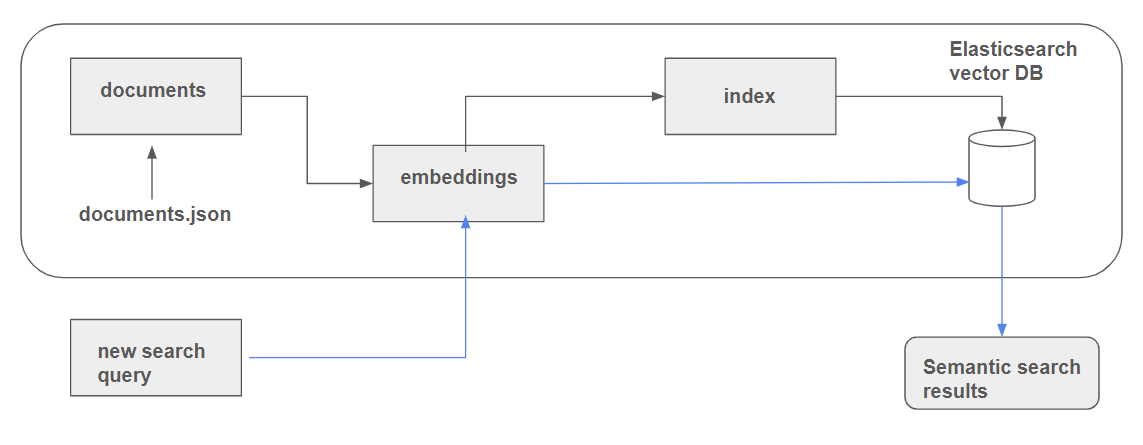

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

#### Step 1: Prepare documents

In [1]:
import json

with open('documents.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [2]:
documents = []

for course_dict in docs_raw:
    for doc in course_dict['documents']:
        doc['course'] = course_dict['course']
        documents.append(doc)

documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [3]:
import torch
print(torch.__version__)

2.4.0+cu118


In [4]:
from sentence_transformers import SentenceTransformer
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# 5. https://www.dllme.com/dll/files/libomp140_x86_64/00637fe34a6043031c9ae4c6cf0a891d/download
# run the above cell, it should work

#### Step 2: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [5]:

model = SentenceTransformer("all-mpnet-base-v2")

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

C:\Users\aksha\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aksha\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
len(model.encode("This is a simple sentence"))

768

In [9]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp'}

In [10]:
#created the dense vector using the pre-trained model
operations = []
for doc in documents:
    # Transforming the title into an embedding using the model
    doc["text_vector"] = model.encode(doc["text"]).tolist()
    operations.append(doc)

In [12]:
operations[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'text_vector': [-0.03570346534252167,
  -0.0689142644405365,
  -0.04448341578245163,
  0.0062501514330506325,
  -0.04224711284041405,
  -0.006454005837440491,
  0.02754814736545086,
  -0.01861027628183365,
  -0.052037470042705536,
  -0.002404735190793872,
  0.05745450034737587,
  -0.015592597424983978,
  0.015488816425204277,
  0.0987015962600708,
  0.015649540349841118,
  -0.06

#### Step 3: Setup ElasticSearch connection 

In [13]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '81ce85ef54b0', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'BkUrI4rYRIaUZv_a4twyBA', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [14]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} ,
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [15]:
index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

#### Step 5: Add documents into index

In [16]:
for doc in operations:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [17]:
search_term = "windows or mac?"
vector_search_term = model.encode(search_term)

In [18]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [19]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course"])
res["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'jRhh8JAB1ar_jSYiQE5t',
  '_score': 0.71479195,
  '_source': {'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully'}},
 {'_index': 'course-questions',
  '_id': 'oBhi8JAB1ar_jSYiFlFf',
  '_score': 0.6134734,
  '_source': {'question': 'WSL instructions',
   'course': 'mlops-zoomcamp',
   'section': 'Module 1: Introduction',
   'text': 'If you wish to use WSL on your windows machine, here are the setup instructions:\nCommand: Sudo apt install wget\nGet Anaconda download address here. wget <download address>\nTurn on Docker Desktop WFree Download | AnacondaSL2\nCommand: git clone <github repository address>\nVSCODE on WSL\nJupyter: pip3 install jupyter\nAdded by Gregory Morris (gwm1980@gmail.com)\nAll in all softwares a

In [20]:
response = es_client.search(
    index=index_name,
    query = {
        "bool":{
            "must":{
                "multi_match":{
                    "query": "windows or python?",
                    "fields": ["text", "question", "course", "title"],
                    "type": "best_fields"
                }
            },
            "filter":{
                "term":{
                    "course":"data-engineering-zoomcamp"
                }
            }
        }
    }
)

In [21]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': '0xhh8JAB1ar_jSYiVE5c',
  '_score': 7.728908,
  '_source': {'text': 'Problem: If you have already installed pgcli but bash doesn\'t recognize pgcli\nOn Git bash: bash: pgcli: command not found\nOn Windows Terminal: pgcli: The term \'pgcli\' is not recognized…\nSolution: Try adding a Python path C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts to Windows PATH\nFor details:\nGet the location: pip list -v\nCopy C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\site-packages\n3. Replace site-packages with Scripts: C:\\Users\\...\\AppData\\Roaming\\Python\\Python39\\Scripts\nIt can also be that you have Python installed elsewhere.\nFor me it was under c:\\python310\\lib\\site-packages\nSo I had to add c:\\python310\\lib\\Scripts to PATH, as shown below.\nPut the above path in "Path" (or "PATH") in System Variables\nReference: https://stackoverflow.com/a/68233660',
   'section': 'Module 1: Docker and Terraform',
   'question': 'PGCLI - pg

#### Step 7: Perform Keyword search with Semantic Search (Hybrid/Advanced Search)

In [22]:
# Note: I made a minor modification to the query shown in the notebook here
# (compare to the one shown in the video)
# Included "knn" in the search query (to perform a semantic search) along with the filter  
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

In [23]:
response = es_client.search(
    index=index_name,
    query={
        "match": {"section": "General course-related questions"},
    },
    knn=knn_query,
    size=5
)

In [24]:
response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'jRhh8JAB1ar_jSYiQE5t',
  '_score': 11.614713,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965467259287834,
    -0.0006261487724259496,
    -0.016629496589303017,
    0.05285152047872543,
    0.054765284061431885,
    -0.031339891254901886,
    0.029942581430077553,
    -0.04808562994003296,
    0.04467552527785301,
    0.0058394744992256165,
    0.016233038157224655,
    0.012001179158687592,
    -0.03122226521372795,
    0.016600513830780983,
    -0.04886903986334801,
    -0.06496306508779526,
    0.046434223651885986,
    -0.009297751821577549,
    -0.0642528384923935,
    -0.01373270247131586,
    -0.01597621664404869,
    0.008629538118839264,
    -0.02447898499

In [27]:
knn_query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000
}

response = es_client.search(
    index=index_name,
    query = {
        "match":{
            "course":"data-engineering-zoomcamp"
        },
    },
    knn=knn_query,
    size=5
)

response["hits"]["hits"]

[{'_index': 'course-questions',
  '_id': 'jRhh8JAB1ar_jSYiQE5t',
  '_score': 1.493706,
  '_source': {'text': 'Yes! Linux is ideal but technically it should not matter. Students last year used all 3 OSes successfully',
   'section': 'General course-related questions',
   'question': 'Environment - Is the course [Windows/mac/Linux/...] friendly?',
   'course': 'data-engineering-zoomcamp',
   'text_vector': [-0.026965467259287834,
    -0.0006261487724259496,
    -0.016629496589303017,
    0.05285152047872543,
    0.054765284061431885,
    -0.031339891254901886,
    0.029942581430077553,
    -0.04808562994003296,
    0.04467552527785301,
    0.0058394744992256165,
    0.016233038157224655,
    0.012001179158687592,
    -0.03122226521372795,
    0.016600513830780983,
    -0.04886903986334801,
    -0.06496306508779526,
    0.046434223651885986,
    -0.009297751821577549,
    -0.0642528384923935,
    -0.01373270247131586,
    -0.01597621664404869,
    0.008629538118839264,
    -0.024478984996

#### References

1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch